# このスクリプトは、DomoGPTを使用してMagicETLの説明を生成します

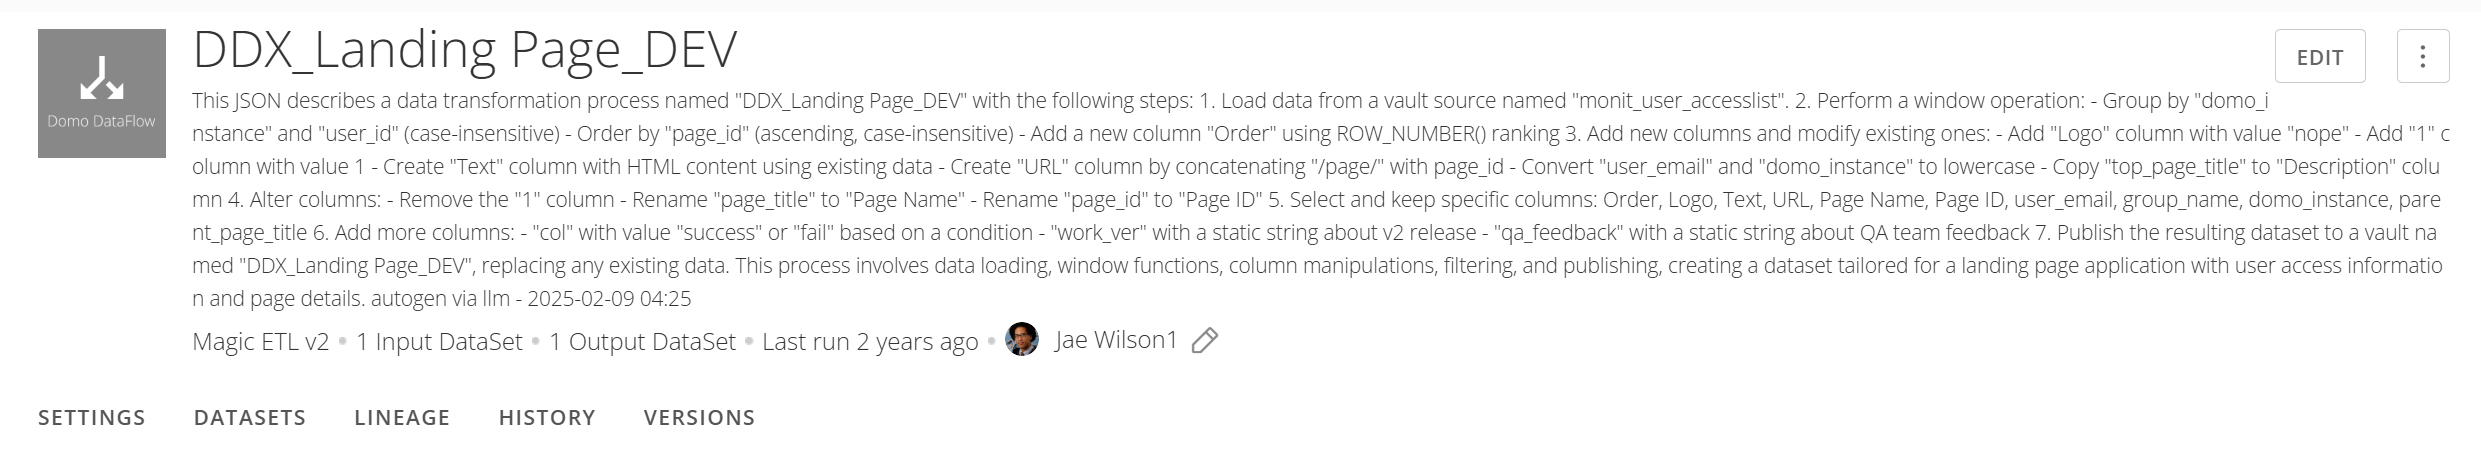

In [1]:
DATAFLOW_ID = 12

In [2]:
import domojupyter as dj
import domolibrary_execution.utils.domojupyter as dxdj

async def generate_auth():
    return await dxdj.generate_token_auth(
        domo_instance = dxdj.which_environment(),
        domojupyter_fn = dj) 

auth = await generate_auth()

🎉 token_auth token retrieved from domo-community ⚙️


In [9]:
import domolibrary.client.DomoError as dmde
import domolibrary.client.DomoAuth as dmda

import routes.dataflow as dataflow_routes
import models.dataflow_model as dataflow_model

import pandas as pd
from pprint import pprint

def get_dataflow_descriptive_data(dataflow_id : int ,
                                  auth : dmda.DomoAuth,
                                  debug_api: bool = False,
                                 return_raw: bool = False,
                                  ignore_existing_description: bool = False
                                 ):
    
    """
    extract data from the dataflow definition that might be useful in producing a description of the dataflow
    
    データフローの説明を作成する際に有用かもしれないデータを、データフロー定義から抽出する
    """
    
    res = dataflow_routes.get_dataflow_by_id_sync(dataflow_id = dataflow_id,
                                                  auth = auth,
                                                  debug_api = debug_api)
    
    if return_raw:
        return res
    
    if not ignore_existing_description and res.response.get('description') and "autogen" in res.response.get('description') :
        raise dmde.DomoError(message = f"dataflow_id {dataflow_id} description was already autogenerated")
    
    return dataflow_model.llm_dataflow_process_definition(res)


descriptive_data = None

try:
    descriptive_data = get_dataflow_descriptive_data(DATAFLOW_ID , auth = auth,
                                                     debug_api = True,
                                                     return_raw = False,
                                                     ignore_existing_description = True)
    pprint(descriptive_data)
except dmde.DomoError as e:
    print(e)


{'body': None,
 'headers': {'x-domo-developer-token': '7b92f788635a46b82f914b8ef63daf8658fcbf0da9eabc8b'},
 'method': 'GET',
 'url': 'https://domo-community.domo.com/api/dataprocessing/v1/dataflows/12'}
{'dataflow_actions': [{'dataSourceId': '80c4a085-2cb7-4917-a956-ee11e3d838bb',
                       'executeFlowWhenUpdated': False,
                       'gui': {'color': 3238043,
                               'colorSource': None,
                               'sampleJson': None,
                               'x': 156,
                               'y': 204},
                       'id': '0fab5ca6-3d86-4e43-8daf-2a5fed0d4e40',
                       'name': 'Governance_Dataflow Details',
                       'onlyLoadNewVersions': False,
                       'pseudoDataSource': False,
                       'recentVersionCutoffMs': 0,
                       'settings': {},
                       'truncateRows': False,
                       'truncateTextColumns': False,
    

In [4]:
import models.model as model
import datetime as dt

def generate_new_description(description : str) -> str:
    return f'{description}\n autogen via llm - {dt.datetime.now().strftime("%Y-%m-%d %H:%M")}'

def llm_describe_dataflow(descriptive_data, return_raw: bool = False, debug_api : bool = False):
    """this function takes a json definition and describes in plain english
    この関数はJSON定義を受け取り、domoGPTを使用して平易な英語で説明します
    """
    
    endpoint = model.EndpointHandler._from_creds_account(domo_instance = 'domo-community')
    messages = dataflow_model.generate_llm_messages()
    messages = endpoint.invoke_message(data = descriptive_data,
                                       debug_api = debug_api,
                                       messages = messages
                                      )
    
    if return_raw:
        return messages

    return generate_new_description( messages.messages[-1].content)

dataflow_description = llm_describe_dataflow(descriptive_data = descriptive_data)

dataflow_description

'The JSON describes a Domo ETL dataflow named "Domo Governance Dataflow" with ID 12. This dataflow consists of six sequential actions:\n\n1. LoadFromVault: Data is loaded from a source named "Governance_Dataflow Details" (ID: 0fab5ca6-3d86-4e43-8daf-2a5fed0d4e40).\n\n2. GroupBy: The data is grouped by the "Name" field. Four new fields are created:\n   - "Inputs": Concatenates "Input Dataset Name" values with commas\n   - "Outputs": Concatenates "Output Dataset Name" values with commas\n   - "Input IDs": Concatenates "Input Dataset ID" values with commas\n   - "Outputs IDs": Concatenates "Output Dataset ID" values with commas\n\n3. MergeJoin: An inner join is performed between the results of steps 1 and 2, using the "Name" field as the join key. The "Name" field from the second dataset is renamed to "Name_1".\n\n4. Unique: Duplicate rows are removed based on the "Name" field, without considering case sensitivity.\n\n5. ReplaceString: In the fields "Inputs", "Outputs", "Input IDs", and "

In [10]:
def update_dataflow(dataflow_id, 
                    auth : dmda.DomoAuth,
                    new_description : str , 
                    debug_api : bool = False):
    """
    update dataflow description using standard domo APIs as a replacement for typing it in by hand
    
    手動で入力する代わりに、標準のDomo APIを使用してデータフローの説明を更新する
    """
    res = dataflow_routes.get_dataflow_by_id_sync(dataflow_id = dataflow_id, auth = auth, debug_api = debug_api)
    
    update_dataflow_body = dataflow_routes.generate_update_dataflow_body(obj = res.response, description = new_description)

    return dataflow_routes.update_dataflow_by_id_sync(dataflow_id = dataflow_id, 
                                               auth = auth,
                                               dataflow_body = update_dataflow_body ,
                                               debug_api = debug_api)

update_dataflow(
    dataflow_id = DATAFLOW_ID,
    auth = auth,
    new_description = dataflow_description, 
    debug_api = False
)

ResponseGetData(status=200, response={'gui': {'version': '1.0', 'canvases': {'default': {'canvasSettings': {'coarserGrid': False, 'backgroundVariant': 'None'}, 'elements': [{'type': 'Tile', 'id': '0fab5ca6-3d86-4e43-8daf-2a5fed0d4e40', 'x': 156, 'y': 204, 'color': 3238043, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '7f1443c9-5584-4980-8546-4434286c16dc', 'x': 300, 'y': 336, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '4bacccc7-8aa1-408d-a9c1-6572e4be63ee', 'x': 420, 'y': 204, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '6b311369-d32a-46a2-bb48-d0bba47257fd', 'x': 528, 'y': 204, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '18c95e6c-d0ca-4a1f-8cff-5c01b7e54d90', 'x': 780, 'y': 204, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': 'fc028731-4f58-4e98-a923-bdc83fca8d74', 'x': 924, 'y': 204, 'color': None, 'colorSource': None, 'samp

In [6]:
def process_dataflow(dataflow_id,
                     auth : dmda.DomoAuth,
                     debug_prn: bool = False,
                     debug_api: bool = False,
                     ignore_existing_description: bool = False,
                     **kwargs):
    """
    update dataflow description using standard domo APIs as a replacement for typing it in by hand
    
    手動で入力する代わりに、標準のDomo APIを使用してデータフローの説明を更新する
    """
    
    if debug_prn:
        index = kwargs.get('index')
        outOf = kwargs.get('outOf')
        end = None
        
        if index and outOf:
            end = f" {index} out of {outOf}"
        
        print(f'starting {dataflow_id}{end or ""}')
    
    try:
        dataflow_descriptive_data = get_dataflow_descriptive_data(dataflow_id , auth = auth, debug_api=debug_api, ignore_existing_description = ignore_existing_description)
         
        dataflow_description = llm_describe_dataflow(descriptive_data = descriptive_data, debug_api = debug_api)

        return update_dataflow(dataflow_id, 
                        auth = auth, 
                        new_description = dataflow_description,
                        debug_api = debug_api)
    
    except dmde.DomoError as e:
        print(f"{e} - on dataflow - {dataflow_id}")


process_dataflow(12, auth = auth, ignore_existing_description = True)

ResponseGetData(status=200, response={'gui': {'version': '1.0', 'canvases': {'default': {'canvasSettings': {'coarserGrid': False, 'backgroundVariant': 'None'}, 'elements': [{'type': 'Tile', 'id': '0fab5ca6-3d86-4e43-8daf-2a5fed0d4e40', 'x': 156, 'y': 204, 'color': 3238043, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '7f1443c9-5584-4980-8546-4434286c16dc', 'x': 300, 'y': 336, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '4bacccc7-8aa1-408d-a9c1-6572e4be63ee', 'x': 420, 'y': 204, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '6b311369-d32a-46a2-bb48-d0bba47257fd', 'x': 528, 'y': 204, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': '18c95e6c-d0ca-4a1f-8cff-5c01b7e54d90', 'x': 780, 'y': 204, 'color': None, 'colorSource': None, 'sampleJson': None}, {'type': 'Tile', 'id': 'fc028731-4f58-4e98-a923-bdc83fca8d74', 'x': 924, 'y': 204, 'color': None, 'colorSource': None, 'samp

In [8]:
import routes.datacenter as datacenter_routes

def main(auth, debug_api: bool = False, debug_prn: bool = False):
    """
    now do that for all the MagicETL dataflows in the datacenter
    
    今度は、データセンター内のすべてのMagicETLデータフローに対してそれを実行する
    """
    
    
    # automation is doing the same thing many times. this step is a replacement for doing it by hand in the Domo Datacenter.
    # 自動化とは、同じことを何度も行うことです。このステップは、Domoデータセンターで手動で行うことの代替となります。
    query_body = {
        "entities":["DATAFLOW"],"filters":[
        {"filterType":"term","field":
         "owned_by_id","value":"1893952720:USER",
         "name":"Jae Wilson1","not":False}],
                  "combineResults":True,"query":"*","count":30,"offset":0,
    }

    res = datacenter_routes.search_datacenter_sync(
        auth = auth,
        query_body= query_body,
        debug_api = debug_api
    )

    
    # 各ETLにLLM説明生成を適用する
    # apply the llm description generation to each etl
    for index, obj in enumerate(res.response['searchObjects']):
        process_dataflow(dataflow_id = obj['databaseId'],
                         auth = auth,
                         index = index,
                         outOf = len(res.response['searchObjects']),
                         debug_prn = debug_prn
                        )
        

main(auth = auth, debug_prn = True, debug_api = False)

starting 344
🛑  DomoError 🛑 - function: Forbidden || error - on dataflow - 344
starting 123 1 out of 29
🛑  DomoError 🛑 - function: dataflow_id 123 description was already autogenerated - on dataflow - 123
starting 124 2 out of 29
🛑  DomoError 🛑 - function: dataflow_id 124 description was already autogenerated - on dataflow - 124
starting 60 3 out of 29
🛑  DomoError 🛑 - function: dataflow_id 60 description was already autogenerated - on dataflow - 60
starting 227 4 out of 29
🛑  DomoError 🛑 - function: dataflow_id 227 description was already autogenerated - on dataflow - 227
starting 86 5 out of 29
🛑  DomoError 🛑 - function: Forbidden || error - on dataflow - 86
starting 185 6 out of 29
🛑  DomoError 🛑 - function: dataflow_id 185 description was already autogenerated - on dataflow - 185
starting 132 7 out of 29
🛑  DomoError 🛑 - function: dataflow_id 132 description was already autogenerated - on dataflow - 132
starting 131 8 out of 29
🛑  DomoError 🛑 - function: dataflow_id 131 description